# PKS Module Architecture Analysis

This notebook provides a **comprehensive analysis of PKS module architectures**, classifying modules by their domain composition.

## Module Types

| Type | Canonical Domains | Function |
|------|-------------------|----------|
| **α (Alpha)** | KS-AT-ACP | Minimal elongation module |
| **β (Beta)** | KS-AT-KR-ACP | Keto-reduction module |
| **γ (Gamma)** | KS-AT-DH-KR-ACP | Dehydration module |
| **δ (Delta)** | KS-AT-DH-ER-KR-ACP | Full reduction module |
| **Termination** | + TE or R | Product release |
| **Tailoring** | + cMT, oMT | Methylation |

## Analysis Goals
1. Classify all modules by architecture type
2. Compare structural properties across module types
3. Analyze domain distances and spatial organization
4. Identify unusual or hybrid module architectures


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries loaded successfully")


Libraries loaded successfully


---
## 1. Load Data and Extract Domain Composition


In [16]:
# Load combined data (has domain composition info) and module macroproperties
combined_df = pd.read_csv('MP_IA_IDO_combined.csv', low_memory=False)
module_mp = pd.read_csv('MP_PKS.csv')
ido_df = pd.read_csv('IDO_out.csv', low_memory=False)

print(f"Combined data: {combined_df.shape}")
print(f"Module macroproperties: {module_mp.shape}")
print(f"IDO data: {ido_df.shape}")


Combined data: (8005, 1043)
Module macroproperties: (8003, 12)
IDO data: (7733, 1029)


In [17]:
# Extract domain composition from column structure
# The domain.XXX.start columns indicate which domains are present (non-NaN = present)

def extract_domains_from_columns(row, domain_start_cols):
    """Extract list of domains present based on which domain.XXX.start columns have values"""
    domains = []
    for col in domain_start_cols:
        if pd.notna(row[col]):
            # Extract domain name from column like 'domain.KS.start' -> 'KS'
            domain_name = col.replace('domain.', '').replace('.start', '')
            domains.append(domain_name)
    return domains

def get_catalytic_domains(domain_list):
    """Get only catalytic (non-linker) domains"""
    return [d for d in domain_list if len(d) <= 3 or not d.endswith('L')]

# Find all domain.XXX.start columns
domain_start_cols = [c for c in ido_df.columns if c.startswith('domain.') and c.endswith('.start')]
print(f"Found {len(domain_start_cols)} domain position columns")

# Extract domains for each row
ido_df['domain_list'] = ido_df.apply(lambda row: extract_domains_from_columns(row, domain_start_cols), axis=1)
ido_df['catalytic_domains'] = ido_df['domain_list'].apply(get_catalytic_domains)
ido_df['domain_signature'] = ido_df['catalytic_domains'].apply(lambda x: '-'.join(sorted(set(x))))

print("\nSample domain compositions (first 10):")
print(ido_df['catalytic_domains'].head(10).tolist())


Found 31 domain position columns

Sample domain compositions (first 10):
[['ACP', 'AT', 'KS'], ['ACP', 'AT', 'KS'], ['ACP', 'AT', 'KS'], ['ACP', 'AT', 'KS'], ['ACP', 'AT', 'KS'], ['ACP', 'AT', 'DH', 'KR', 'KS'], ['ACP', 'AT', 'DH', 'KR', 'KS'], ['ACP', 'AT', 'DH', 'KR', 'KS'], ['ACP', 'AT', 'DH', 'KR', 'KS'], ['ACP', 'AT', 'DH', 'KR', 'KS']]


In [18]:
# Classify modules by architecture type
def classify_module(catalytic_domains):
    """Classify module by its domain composition"""
    if not catalytic_domains:
        return 'Unknown'
    
    domains = set(catalytic_domains)
    
    # Check for essential domains
    has_KS = 'KS' in domains
    has_AT = 'AT' in domains
    has_ACP = 'ACP' in domains
    has_KR = 'KR' in domains
    has_DH = 'DH' in domains
    has_ER = 'ER' in domains
    has_TE = 'TE' in domains
    has_R = 'R' in domains
    has_cMT = 'cMT' in domains
    has_oMT = 'oMT' in domains
    
    # Base classification
    if has_KS and has_AT and has_ACP:
        if has_DH and has_ER and has_KR:
            base_type = 'Delta'
        elif has_DH and has_KR:
            base_type = 'Gamma'
        elif has_KR:
            base_type = 'Beta'
        else:
            base_type = 'Alpha'
    else:
        return 'Incomplete'
    
    # Check for termination domains
    if has_TE:
        base_type += '+TE'
    elif has_R:
        base_type += '+R'
    
    # Check for methyltransferases
    if has_cMT or has_oMT:
        mt_type = []
        if has_cMT:
            mt_type.append('cMT')
        if has_oMT:
            mt_type.append('oMT')
        base_type += '+' + '/'.join(mt_type)
    
    return base_type

ido_df['module_type'] = ido_df['catalytic_domains'].apply(classify_module)

# Count module types
module_type_counts = ido_df['module_type'].value_counts()
print("Module Architecture Distribution:")
print(module_type_counts)


Module Architecture Distribution:
module_type
Gamma         3094
Beta          2113
Delta         1116
Alpha          790
Gamma+TE       175
Alpha+TE       104
Beta+TE         95
Gamma+cMT       75
Beta+cMT        30
Beta+oMT        30
Gamma+R         25
Delta+TE        25
Alpha+oMT       15
Alpha+R         15
Alpha+cMT       10
Unknown         10
Delta+cMT        5
Beta+R           5
Incomplete       1
Name: count, dtype: int64


---
## 2. Module Type Distribution Analysis


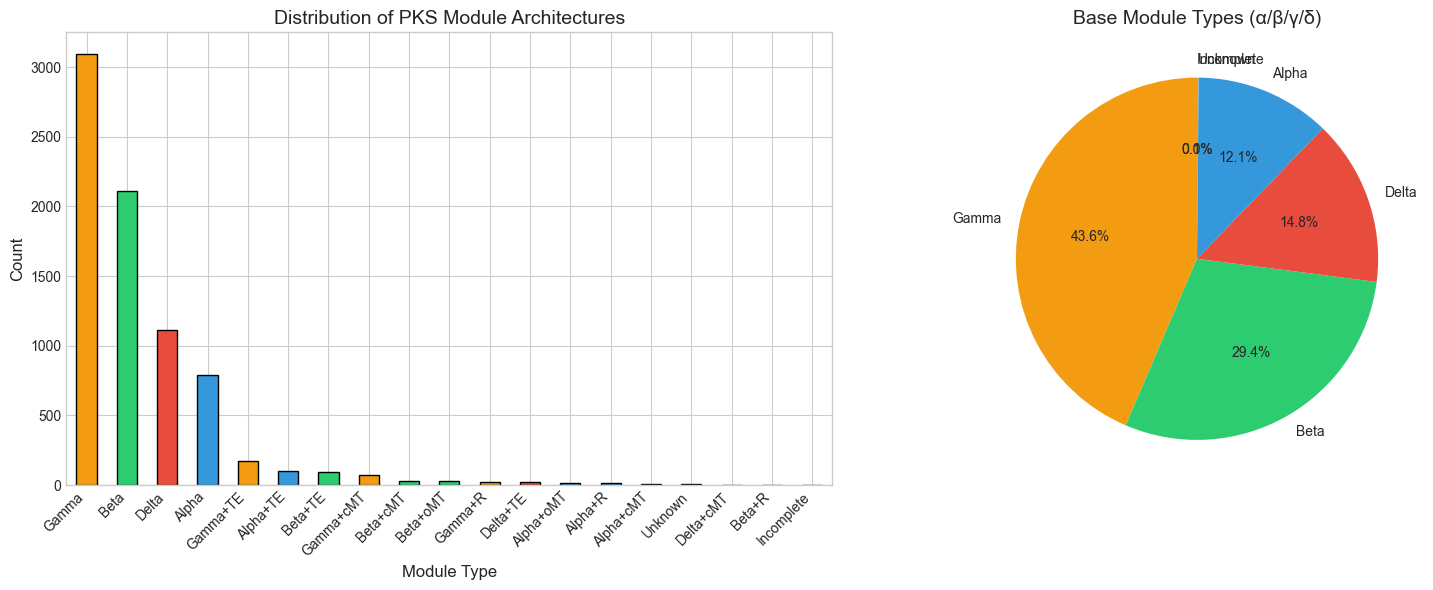


MODULE TYPE SUMMARY
Alpha     :   934 ( 12.1%)
Beta      :  2273 ( 29.4%)
Gamma     :  3369 ( 43.6%)
Delta     :  1146 ( 14.8%)


In [19]:
# Visualize module type distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
ax = axes[0]
colors = {
    'Alpha': '#3498db', 'Beta': '#2ecc71', 'Gamma': '#f39c12', 'Delta': '#e74c3c',
    'Alpha+TE': '#85c1e9', 'Beta+TE': '#82e0aa', 'Gamma+TE': '#f9e79f', 'Delta+TE': '#f5b7b1',
}
bar_colors = [colors.get(t.split('+')[0], '#95a5a6') for t in module_type_counts.index]
module_type_counts.plot(kind='bar', ax=ax, color=bar_colors, edgecolor='black')
ax.set_xlabel('Module Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of PKS Module Architectures', fontsize=14)
plt.sca(ax)
plt.xticks(rotation=45, ha='right')

# Pie chart of base types
ax = axes[1]
base_types = ido_df['module_type'].apply(lambda x: x.split('+')[0] if '+' in x else x)
base_counts = base_types.value_counts()
base_colors = [colors.get(t, '#95a5a6') for t in base_counts.index]
ax.pie(base_counts, labels=base_counts.index, autopct='%1.1f%%', colors=base_colors, startangle=90)
ax.set_title('Base Module Types (α/β/γ/δ)', fontsize=14)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*50)
print("MODULE TYPE SUMMARY")
print("="*50)
for base_type in ['Alpha', 'Beta', 'Gamma', 'Delta']:
    count = base_counts.get(base_type, 0)
    pct = count / len(ido_df) * 100 if len(ido_df) > 0 else 0
    print(f"{base_type:10s}: {count:5d} ({pct:5.1f}%)")


In [20]:
# Analyze termination and tailoring domains
termination_count = ido_df['module_type'].str.contains('TE|\\+R', regex=True).sum()
tailoring_count = ido_df['module_type'].str.contains('MT', regex=True).sum()

print("Special Domain Analysis:")
print(f"  Modules with termination domain (TE/R): {termination_count} ({termination_count/len(ido_df)*100:.1f}%)")
print(f"  Modules with methyltransferase (cMT/oMT): {tailoring_count} ({tailoring_count/len(ido_df)*100:.1f}%)")

# Detailed breakdown
print("\nTermination modules:")
te_modules = ido_df[ido_df['module_type'].str.contains('TE', na=False)]['module_type'].value_counts()
print(te_modules)

print("\nTailoring modules (with MTs):")
mt_modules = ido_df[ido_df['module_type'].str.contains('MT', na=False)]['module_type'].value_counts()
print(mt_modules)


Special Domain Analysis:
  Modules with termination domain (TE/R): 444 (5.7%)
  Modules with methyltransferase (cMT/oMT): 165 (2.1%)

Termination modules:
module_type
Gamma+TE    175
Alpha+TE    104
Beta+TE      95
Delta+TE     25
Name: count, dtype: int64

Tailoring modules (with MTs):
module_type
Gamma+cMT    75
Beta+cMT     30
Beta+oMT     30
Alpha+oMT    15
Alpha+cMT    10
Delta+cMT     5
Name: count, dtype: int64


---
## 3. Structural Properties by Module Type

Compare structural properties across alpha, beta, gamma, and delta modules.


In [ ]:
# Merge module type with macroproperties
# First, create matching key for combined_df
if 'filename' in combined_df.columns and 'filename' in ido_df.columns:
    combined_df['base_filename'] = combined_df['filename'].str.lower()
    ido_df['base_filename'] = ido_df['filename'].str.lower()
    
    # Create a string version of catalytic_domains for merging (lists are unhashable)
    ido_df['catalytic_domains_str'] = ido_df['catalytic_domains'].apply(lambda x: ','.join(x) if isinstance(x, list) else str(x))
    
    # Merge module types - use only hashable columns for drop_duplicates
    merge_cols = ['base_filename', 'module_type', 'catalytic_domains_str']
    module_typed = combined_df.merge(
        ido_df[merge_cols].drop_duplicates(),
        on='base_filename',
        how='left'
    )
    
    # Convert string back to list
    module_typed['catalytic_domains'] = module_typed['catalytic_domains_str'].apply(
        lambda x: x.split(',') if pd.notna(x) and x else []
    )
    
    print(f"Merged data shape: {module_typed.shape}")
    print(f"Module types available: {module_typed['module_type'].nunique()}")
    print(f"Rows with module_type: {module_typed['module_type'].notna().sum()}")
else:
    # Create module type directly from IDO (use this as primary source)
    module_typed = ido_df.copy()
    print(f"Using IDO data directly: {module_typed.shape}")
    
print("\nModule type value counts:")
print(module_typed['module_type'].value_counts())


TypeError: unhashable type: 'list'

In [ ]:
# Extract base module type for comparison
def get_base_type(x):
    """Extract base module type, handling NaN and various formats"""
    if pd.isna(x):
        return None
    x_str = str(x)
    if '+' in x_str:
        return x_str.split('+')[0]
    return x_str

module_typed['base_type'] = module_typed['module_type'].apply(get_base_type)

# Filter to main types for comparison
main_types = ['Alpha', 'Beta', 'Gamma', 'Delta']
main_modules = module_typed[module_typed['base_type'].isin(main_types)].copy()

print(f"Main module types: {len(main_modules)} records")
if len(main_modules) > 0:
    print(main_modules['base_type'].value_counts())
else:
    print("WARNING: No main module types found in merged data!")
    print("Falling back to IDO data...")
    # Use ido_df directly if merge didn't work
    ido_df['base_type'] = ido_df['module_type'].apply(get_base_type)
    main_modules = ido_df[ido_df['base_type'].isin(main_types)].copy()
    module_typed = ido_df.copy()
    print(f"Using IDO data: {len(main_modules)} records")
    print(main_modules['base_type'].value_counts())


In [ ]:
# If we have structural properties in combined data, analyze them
struct_cols = ['n_ca_atoms', 'n_heavy_atoms', 'radius_of_gyration_ca', 'sasa', 'ses_area', 'vdw_volume']
available_struct_cols = [c for c in struct_cols if c in module_typed.columns]

# Check if we have data with valid base_types
valid_typed = module_typed[module_typed['base_type'].isin(main_types)]

if available_struct_cols and len(valid_typed) > 0:
    print(f"Analyzing {len(valid_typed)} modules with structural properties")
    print("\nStructural properties by module type:")
    struct_by_type = valid_typed.groupby('base_type')[available_struct_cols].agg(['mean', 'std', 'count'])
    display(struct_by_type.round(2))
    
    # Visualize
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    colors = {'Alpha': '#3498db', 'Beta': '#2ecc71', 'Gamma': '#f39c12', 'Delta': '#e74c3c'}
    
    for i, col in enumerate(available_struct_cols[:6]):
        ax = axes[i]
        data_to_plot = []
        labels = []
        for mt in main_types:
            d = main_modules[main_modules['base_type'] == mt][col].dropna()
            if len(d) > 0:
                data_to_plot.append(d)
                labels.append(mt)
        
        if data_to_plot:
            bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
            for patch, label in zip(bp['boxes'], labels):
                patch.set_facecolor(colors.get(label, 'gray'))
                patch.set_alpha(0.7)
        else:
            ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes)
        
        ax.set_ylabel(col)
        ax.set_title(f'{col} by Module Type')
    
    plt.suptitle('Structural Properties: Alpha vs Beta vs Gamma vs Delta Modules', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Structural columns not found or no valid module types - skipping structural comparison")
    print(f"Available struct cols: {available_struct_cols}")
    print(f"Valid typed rows: {len(valid_typed) if 'valid_typed' in dir() else 0}")


---
## 4. Inter-Domain Distances by Module Type

Analyze spatial organization differences between module architectures.


In [ ]:
# Analyze inter-domain distances by module type
distance_cols = [c for c in ido_df.columns if c.startswith('dist.')]

# Key distances to analyze
key_distances = ['dist.KS__AT', 'dist.KS__ACP', 'dist.AT__ACP', 'dist.KS__KR', 
                 'dist.KR__ACP', 'dist.DH__KR', 'dist.DH__ACP']
available_distances = [d for d in key_distances if d in distance_cols]

print(f"Available key distances: {len(available_distances)}")

if available_distances:
    # Merge with module types
    dist_by_type = ido_df[['module_type'] + available_distances].copy()
    dist_by_type['base_type'] = dist_by_type['module_type'].apply(
        lambda x: x.split('+')[0] if pd.notna(x) and '+' in str(x) else x
    )
    
    # Filter to main types
    dist_main = dist_by_type[dist_by_type['base_type'].isin(main_types)]
    
    # Summary statistics
    print("\nInter-domain distances by module type (Angstroms):")
    for dist_col in available_distances[:5]:
        print(f"\n{dist_col.replace('dist.', '').replace('__', ' ↔ ')}:")
        stats = dist_main.groupby('base_type')[dist_col].agg(['mean', 'std', 'count']).round(2)
        print(stats)


In [ ]:
# Visualize key distances by module type
if available_distances:
    n_plots = min(6, len(available_distances))
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    colors = {'Alpha': '#3498db', 'Beta': '#2ecc71', 'Gamma': '#f39c12', 'Delta': '#e74c3c'}
    
    for i, dist_col in enumerate(available_distances[:n_plots]):
        ax = axes[i]
        data_to_plot = []
        labels = []
        
        for mt in main_types:
            d = dist_main[dist_main['base_type'] == mt][dist_col].dropna()
            if len(d) > 10:
                data_to_plot.append(d)
                labels.append(f'{mt}\n(n={len(d)})')
        
        if data_to_plot:
            bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
            for j, (patch, label) in enumerate(zip(bp['boxes'], labels)):
                mt_name = label.split('\n')[0]
                patch.set_facecolor(colors.get(mt_name, 'gray'))
                patch.set_alpha(0.7)
        
        title = dist_col.replace('dist.', '').replace('__', ' ↔ ')
        ax.set_ylabel('Distance (Å)')
        ax.set_title(title)
    
    # Hide unused axes
    for j in range(n_plots, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Inter-Domain Distances by Module Architecture', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


---
## 5. Termination vs Non-Termination Modules


In [ ]:
# Compare termination modules (with TE/R) vs non-termination
ido_df['has_termination'] = ido_df['module_type'].str.contains('TE|\\+R', regex=True, na=False)
ido_df['has_tailoring'] = ido_df['module_type'].str.contains('MT', na=False)

print("Module Feature Distribution:")
print(f"  With termination domain: {ido_df['has_termination'].sum()} ({ido_df['has_termination'].mean()*100:.1f}%)")
print(f"  With tailoring (MT): {ido_df['has_tailoring'].sum()} ({ido_df['has_tailoring'].mean()*100:.1f}%)")
print(f"  Standard (no TE/MT): {(~ido_df['has_termination'] & ~ido_df['has_tailoring']).sum()}")

# Compare properties
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Compare by termination status for a key distance
if 'dist.KS__ACP' in ido_df.columns:
    ax = axes[0]
    term = ido_df[ido_df['has_termination']]['dist.KS__ACP'].dropna()
    non_term = ido_df[~ido_df['has_termination']]['dist.KS__ACP'].dropna()
    
    ax.hist(non_term, bins=40, alpha=0.7, label=f'Non-termination (n={len(non_term)})', density=True, color='steelblue')
    ax.hist(term, bins=40, alpha=0.7, label=f'Termination (n={len(term)})', density=True, color='coral')
    ax.set_xlabel('KS ↔ ACP Distance (Å)')
    ax.set_ylabel('Density')
    ax.set_title('KS-ACP Distance: Termination vs Non-Termination')
    ax.legend()

# Termination types
ax = axes[1]
term_types = ido_df[ido_df['has_termination']]['module_type'].value_counts().head(10)
term_types.plot(kind='barh', ax=ax, color='coral')
ax.set_xlabel('Count')
ax.set_title('Termination Module Types')
ax.invert_yaxis()

# Tailoring types
ax = axes[2]
tail_types = ido_df[ido_df['has_tailoring']]['module_type'].value_counts()
if len(tail_types) > 0:
    tail_types.plot(kind='barh', ax=ax, color='purple')
    ax.set_xlabel('Count')
    ax.set_title('Tailoring Module Types (with MTs)')
    ax.invert_yaxis()
else:
    ax.text(0.5, 0.5, 'No tailoring modules found', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()


---
## 6. Summary and Module Architecture Statistics


In [ ]:
# Final summary
print("="*70)
print("PKS MODULE ARCHITECTURE SUMMARY")
print("="*70)

print("\n1. BASE MODULE TYPE DISTRIBUTION:")
print("-"*50)
base_counts = ido_df['module_type'].apply(
    lambda x: x.split('+')[0] if pd.notna(x) and '+' in str(x) else x
).value_counts()

for t in ['Alpha', 'Beta', 'Gamma', 'Delta', 'Incomplete', 'Unknown']:
    count = base_counts.get(t, 0)
    pct = count / len(ido_df) * 100 if len(ido_df) > 0 else 0
    print(f"   {t:15s}: {count:5d} ({pct:5.1f}%)")

print("\n2. SPECIAL DOMAIN PRESENCE:")
print("-"*50)
print(f"   Termination (TE/R): {ido_df['has_termination'].sum():5d} ({ido_df['has_termination'].mean()*100:5.1f}%)")
print(f"   Tailoring (MTs):    {ido_df['has_tailoring'].sum():5d} ({ido_df['has_tailoring'].mean()*100:5.1f}%)")

print("\n3. KEY OBSERVATIONS:")
print("-"*50)
most_common = base_counts.idxmax()
print(f"   • Most common module type: {most_common}")
print(f"   • Total unique architectures: {ido_df['module_type'].nunique()}")

if available_distances and len(dist_main) > 0:
    print("\n4. AVERAGE INTER-DOMAIN DISTANCES BY TYPE (Å):")
    print("-"*50)
    for mt in main_types:
        subset = dist_main[dist_main['base_type'] == mt]
        if len(subset) > 0 and 'dist.KS__ACP' in subset.columns:
            mean_dist = subset['dist.KS__ACP'].mean()
            print(f"   {mt:10s} KS↔ACP: {mean_dist:.1f} Å")
